# 추천 시스템 (Recommender System)   

* 콘텐츠 기반 (Content-based) 추천
    * 제품의 내용을 분석해서 추천, 특히 소비자가 소비하는 제품 중 정보가 많은 제품 (예. 뉴스, 책 등)을 분석시 많이 이용되는 기술  
      * 예. User1이 관심을 가지고 있는 뉴스의 키워드를 찾아내고 비슷한 키워드를 가진 다른 뉴스를 추천 
      * 예. User1은 과거 코미디 영화를 좋아하였기 때문에 코미디 영화 추천
     
* 협업 필터링 (Collaborative Filteirng) 추천
    * 구매, 소비한 제품에 대한 각 소비자의 평가를 받아서 평가 패턴이 비슷한 소비자를 한 집단으로 보고 그 집단에 속한 소비자들의 취향을 활용하는 기술
    * 사람들의 취향이 뚜렷이 구분되는 제품 (예. 영화, 음악, 패션 등)을 추천할 때 더욱 정확함 
      * 예. User1과 제품 평가 패턴이 비슷한 User2, User3이 공통적으로 좋아하는 제품 중에서 User1이 아직 접하지 않은 제품을 추천 


*본 실습은 파이썬 머신러닝 완벽 가이드(권철민, 위키북스, 2020), 이것이 데이터 분석이다 (윤기태, 2020), Python을 이용한 개인화 추천시스템 (임일, 2020) 교재 참고


### 콘텐츠 기반 (Content-based)

* 영화의 장르 정보를 이용하여 유사한 장르의 영화 추천 
   * 영화 장르의 유사도 계산: [cosine similarity ](https://en.wikipedia.org/wiki/Cosine_similarity)
   * MovieLens 1M Dataset 사용
      * https://grouplens.org/datasets/movielens/1m/ 에서 ml-1m.zip 을 다운로드 받아 BigMining/ml-1m 폴더에 올리기 
      * users.dat: 사용자 정보 (user_id, gender, age, occupation, zip-code) 
      * movies.dat: 영화 정보 (movie_id, title, genre)  
      * ratings.dat: 영화 평점 (user_id, movie_id, rating, timestamp)


In [9]:
import time

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Matplotlib의 pyplot 로딩하기
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
user_data =pd.read_csv("/content/drive/My Drive/Colab Notebooks/BigMining/ml-1m/users.dat", names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], sep='::', engine='python')
movie_data =pd.read_csv("/content/drive/My Drive/Colab Notebooks/BigMining/ml-1m/movies.dat", names=['movie_id', 'title', 'genre'], sep='::', engine='python', encoding="ISO-8859-1")
rating_data =pd.read_csv("/content/drive/My Drive/Colab Notebooks/BigMining/ml-1m/ratings.dat", names=['user_id', 'movie_id', 'rating', 'time'], sep='::', engine='python')

In [10]:
print(user_data.shape)
display(user_data.head())

print(movie_data.shape)
display(movie_data.head())

print(rating_data.shape)
display(rating_data.head())

(6040, 5)


,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


(3883, 3)


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


(1000209, 4)


,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


#### 영화 정보 탐색
* 영화 개수, 장르 분표 


In [11]:
# 총 영화의 개수
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 Top 10 년도 출력
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])  # 예. Toy Story (1995)  -> 1995만 추출
movie_data['year'].value_counts().head(10)  # 기본적으로 내림차순으로 정렬

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

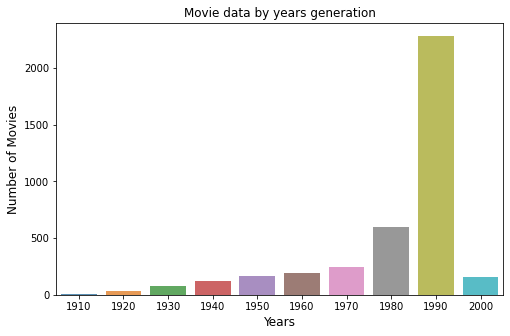

In [12]:
# 연대별 영화의 개수 출력
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
movie_year_term = movie_data['year_term'].value_counts().sort_index()

plt.rcParams['figure.figsize'] = [8, 5]
sns.barplot(movie_year_term.index, movie_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

In [13]:
# 가장 많이 사용된 장르의 조합 출력 (Top 10)
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

In [14]:
# 가장 많이 등장한 장르 추출 (예. Comedy|Romance -> Comedy와 Drama 추출)
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")  # '|’ 구분자로 분리
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
                
print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


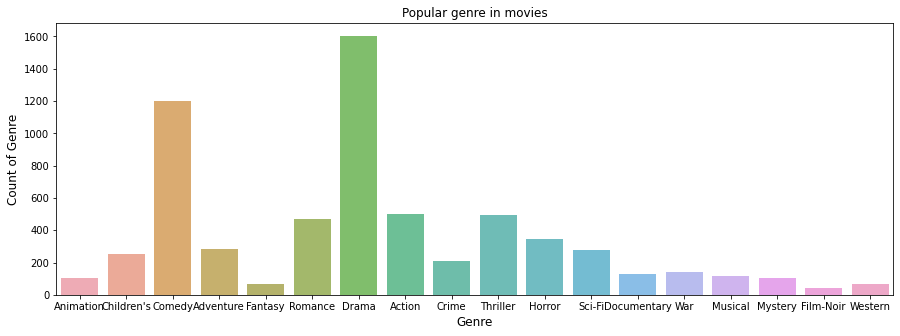

In [15]:
# unique_genre_dict를 이용하여 장르의 속성 그래프 출력
plt.rcParams['figure.figsize'] = [15, 5]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

#### 사용자 정보 탐색
* 사용자 수, 성별, 연령대 

In [16]:
# 사용자의 수 탐색
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


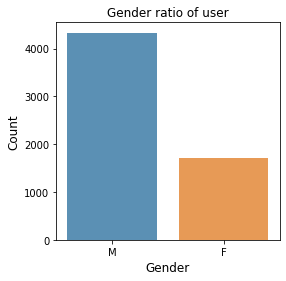

In [17]:
# 사용자 성별 분포
plt.rcParams['figure.figsize'] = [4, 4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [18]:
# 사용자 연령대 탐색
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [19]:
def age_classification(age):
    if age == 1:         # 나이가 1인 값을 outlier로 표기 
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts().sort_index()

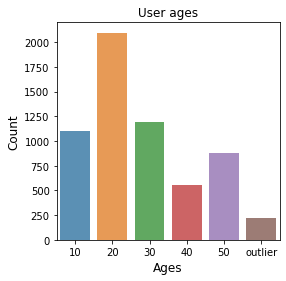

In [20]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

#### 평점 정보 탐색
* 평가 횟수, 평균 평점, 평점 상위 영화 


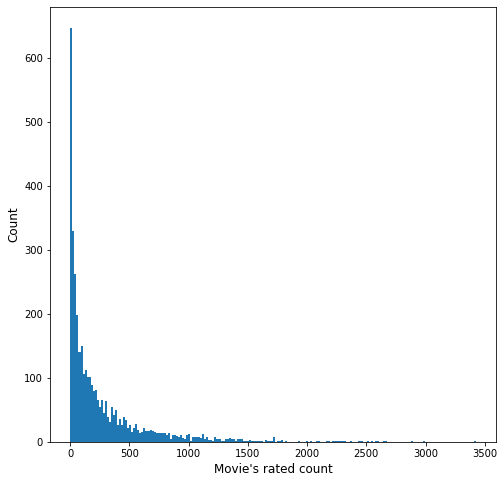

In [21]:
# 각 영화들이 평가받은 횟수 탐색
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [22]:
print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data : 3883
total number of movie rated below 100 : 1687


In [23]:
# 영화별 평균 평점 탐색
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


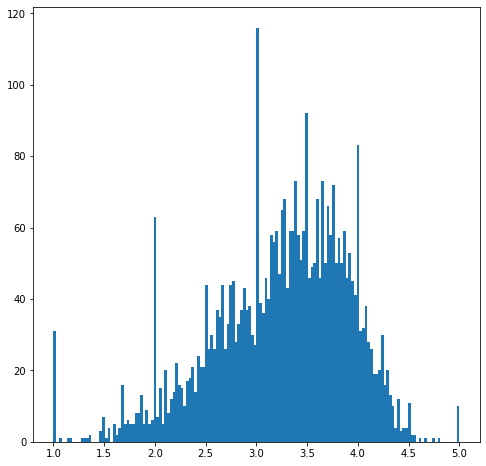

In [24]:
# 영화별 평균 평점 분포
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

In [25]:
# 100번 넘게 평가 받은 영화 중, 평점이 높은 10개의 영화 출력
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


#### 장르의 유사도 (cosine_similarlity) 계산

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해  '|’ 구분자를 공백으로 변경
# Film-Noir Sci-Fi, Childern's를 한 단어로 만들기 
movie_data['genre_token'] = movie_data['genre'].str.replace('|',' ').str.replace('-','').str.replace('\'','')

count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))  # 1개 또는 2개 장르 조합
genre_mat = count_vect.fit_transform(movie_data['genre_token'])
print(genre_mat.shape)
print("장르 사전의 크기:", len(count_vect.vocabulary_))
print("장르 사전의 내용:", count_vect.vocabulary_)  

(3883, 123)
장르 사전의 크기: 123
장르 사전의 내용: {'animation': 29, 'childrens': 37, 'comedy': 45, 'animation childrens': 30, 'childrens comedy': 38, 'adventure': 14, 'fantasy': 83, 'adventure childrens': 16, 'childrens fantasy': 40, 'romance': 108, 'comedy romance': 54, 'drama': 72, 'comedy drama': 48, 'action': 0, 'crime': 59, 'thriller': 117, 'action crime': 5, 'crime thriller': 67, 'action adventure': 1, 'adventure thriller': 26, 'drama romance': 78, 'horror': 94, 'comedy horror': 51, 'adventure romance': 24, 'drama thriller': 80, 'action comedy': 4, 'crime drama': 60, 'scifi': 113, 'drama scifi': 79, 'adventure scifi': 25, 'documentary': 68, 'war': 120, 'drama war': 81, 'musical': 100, 'childrens musical': 42, 'musical romance': 101, 'action drama': 6, 'mystery': 104, 'drama mystery': 77, 'scifi thriller': 114, 'comedy crime': 46, 'crime horror': 63, 'horror thriller': 99, 'drama musical': 76, 'adventure drama': 19, 'action thriller': 11, 'comedy musical': 52, 'adventure crime': 18, 'mystery 

In [27]:
# 장르간 Cosine 유사도 계산 
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim)

(3883, 3883)
[[1.         0.2        0.25819889 ... 0.         0.         0.        ]
 [0.2        1.         0.         ... 0.         0.         0.        ]
 [0.25819889 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         1.         0.57735027]
 [0.         0.         0.         ... 1.         1.         0.57735027]
 [0.         0.         0.         ... 0.57735027 0.57735027 1.        ]]


In [28]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind)

[[   0 3682 2285 ... 2342 2341 1941]
 [1898 1974    1 ... 2544 2543 1941]
 [ 233 2327  904 ... 2304 2301 1941]
 ...
 [ 720  942  941 ... 2280 2278    0]
 [ 720  942  941 ... 2280 2278    0]
 [3882 2619  277 ... 2191 2190    0]]


In [29]:
def find_sim_movie(df, sorted_ind, title_name, top_n):
    
    # 인자로 입력된 movie_data DataFrame에서 'title' 컬럼이 입력된 title_name 값인 DataFrame추출
    title_movie = df[df['title'] == title_name]
    
    # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고 
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n 개의 index 추출
    title_index = title_movie.index.values
 
    # 기준 영화 index를 제외
    # similar_indexes = similar_indexes[similar_indexes != title_index]

    similar_indexes = sorted_ind[title_index, :(top_n)]
    
    # 추출된 top_n index들 출력. top_n index는 2차원 데이터임 
    # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
    print(similar_indexes)

    similar_indexes = similar_indexes.reshape(-1)
    
    return df.iloc[similar_indexes]

In [30]:
similar_movies = find_sim_movie(movie_data, genre_sim_sorted_ind, 'Godfather, The (1972)',10)
similar_movies[['title', 'genre_token']]

[[ 847 1954   41 1203 2843 2125  489 1884 2471 3821]]


,title,genre_token
847,"Godfather, The (1972)",Action Crime Drama
1954,"Godfather: Part III, The (1990)",Action Crime Drama
41,Dead Presidents (1995),Action Crime Drama
1203,"Godfather: Part II, The (1974)",Action Crime Drama
2843,"Limey, The (1999)",Action Crime Drama
2125,"Untouchables, The (1987)",Action Crime Drama
489,Menace II Society (1993),Action Crime Drama
1884,"French Connection, The (1971)",Action Crime Drama Thriller
2471,"Corruptor, The (1999)",Action Crime Drama Thriller
3821,Turn It Up (2000),Crime Drama


### 협업 필터링 (Collaborative Filteirng)
* Surprise 패키지 이용 (http://surpriselib.com/) 
    * scikit 패키지의 일부로 파이썬 기반의 추천 시스템 구축을 위한 전용 패키지
    * 윈도우에 설치시 MS Visual Studio Build Tools 2015 이상의 버전 필요 
    * 주요 장점
       * 다양한 추천 알고리즘 (User/Item-based kNN, SVD, SVD++, NMF 등)을 쉽게 적용하여 추천 시스템 구축 가능 
       * scikit-learn과 유사한 API를 사용하여 모델 학습, 평가, 하이퍼파라미터 튜닝 등의 기능 제공 (예. fit, predict, train_test_split, cross_validate, GridSearchCV 등)

* 가장 많이 사용되는 두 가지 유형의 협업 필터링 알고리즘
    * Neighborhood-Based Approach 
        * k-최근접 이웃 알고리즘(kNN): 성향이 비슷한 k 명의 이웃들이 좋아한 제품 추천
        * KNNBasic, KNNWithMeans, KNNWithZscore       
    * Matrix Factorization Approach 
        * 사용자와 제품에 대한 k개의 잠재 요인 값을 계산하여 추천 (사용자와 제품의 잠재 요인값을 이용하여 특정 사용자의 특정 제품에 대한 예상 평점 계산)
        * SVD(singular value decomposition), SVD++, NMF(non-negative matrix factorization)
  
* 영화의 평점 정보(rating_data)를 이용하여 Top-10 영화 추천 
    * Suprise 패키지의 KNNWithmeans, SVD 알고리즘 사용, 추천 결과 비교 

In [3]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 6.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633722 sha256=231e379209ef993851ca43c8d2e7d925be67f15db739cc33577f6c6fb398300b
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [4]:
from surprise import KNNWithMeans, SVD
from surprise import Reader, Dataset 
from surprise import accuracy 
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
import pandas as pd

In [11]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [12]:
# Surprise 패키지를 사용하기 위한 사전 작업
# Reader 클래스에 평가 척도 지정후 Surprise의 데이터 셋 클래스로 읽어옴
reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)

# 80%를 학습데이터, 20%를 시험용 데이터로 나눔
trainset, testset = train_test_split(data, test_size = 0.20)

#### Neighborhood-Based Approach

##### 모델 학습

In [35]:
# KNNWith Means 파라미터 정보
# https://surprise.readthedocs.io/en/latest/knn_inspired.html

my_sim_option = {'name':'pearson', 'user_based':True }
#  유사도: 기본 msd (means square difference), cosine, pearson_baseline, pearson
#  user_based: 기본 True, user 기반 또는  item 기반의 유사도 계산을 결정

algo = KNNWithMeans(
    k = 15, min_k = 5,   #  고려할 최대, 최소 이웃의 수 
    sim_options = my_sim_option
    )

# KNNwithMeans 모델 학습 
train_start = time.time()
algo.fit(trainset) #약 1분 40초 소요
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

Computing the pearson similarity matrix...
Done computing similarity matrix.
training time of model: 115.84 seconds


##### 평점 예측
* 시험용 데이터의 평점 예측 후 실제 평점과 비교하여 오차 측정 



In [36]:
train_start = time.time()
predictions = algo.test(testset) # 약 2분 30초 소요 
train_end = time.time()
print("test time of model: %.2f seconds" % (train_end - train_start))

test time of model: 162.93 seconds


In [37]:
# 시험용 데이터의 예측 오차가 작을 수록 정확도가 높음
# RMSE(Root Mean Squared Error, 평균 제곱근 오차) 
# MAE(Mean Absolute Error, 평균 절대 오차) 

print("RMSE, MAE of test dataset in KNNWithMeans model:")
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE, MAE of test dataset in KNNWithMeans model:
RMSE: 0.9428
MAE:  0.7428


0.7427960524204901

In [38]:
print('prediction type :',type(predictions), ' size:',len(predictions))
print('prediction 결과의 최초 5개 추출')
[ (pred.uid, pred.iid, pred.est) for pred in predictions[:5] ]

prediction type : <class 'list'>  size: 200042
prediction 결과의 최초 5개 추출


[(4645, 1265, 4.3556198871255845),
 (3195, 3809, 3.6352160973578482),
 (3793, 1923, 2.7271712681404683),
 (368, 3753, 4.211150051474106),
 (1923, 1969, 1.9686404058832319)]

##### Top-10 Item 추천
* 특정 User (user_id = 24)를 위한 Top-10 영화 추천 
    * 시험용 데이터셋 중에서 해당 User의 예측 평점이 높은 영화 10개 추천  

In [39]:
# user_id가 24인 사용자의 예측 평점, 실제 평점 데이터 추출 
target_user_id = 24

target_predict_dict = {}
for uid, mid, rating, predicted_rating, _ in predictions:
    if uid == target_user_id:
        target_predict_dict[mid] = predicted_rating, rating

target_predict_dict

{110: (4.122597301000611, 4.0),
 153: (3.400368948403528, 4.0),
 296: (4.894674950119528, 5.0),
 329: (3.458047188609964, 3.0),
 380: (3.819145948237175, 3.0),
 527: (4.247769888810203, 5.0),
 648: (3.4293496523943516, 3.0),
 912: (4.3508436195416, 5.0),
 1027: (3.1082166747353246, 3.0),
 1230: (4.566683293925046, 5.0),
 1265: (4.002026037080014, 4.0),
 1296: (4.343465683840155, 5.0),
 1358: (4.267238906344103, 5.0),
 1377: (3.7297563791777546, 4.0),
 1569: (3.7924340124792555, 4.0),
 2100: (3.706765937055251, 4.0),
 2144: (4.295429791597334, 4.0),
 2243: (3.9853280381447207, 4.0),
 2352: (4.082504247287952, 4.0),
 2396: (4.5909677555661155, 4.0),
 2406: (4.068241469744193, 4.0),
 2407: (4.01569588294425, 4.0),
 2640: (3.8824770267246564, 4.0),
 2795: (4.446988316288167, 4.0),
 2987: (4.012293395653623, 4.0),
 3526: (4.065459967234075, 4.0),
 3608: (3.851050564986826, 3.0)}

In [41]:
import operator

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화 선정
target_top10_predicted = sorted(target_predict_dict.items(), 
                                key=operator.itemgetter(1), reverse=True)[:10]

# 예측 평점이 높은 Top 10 영화 추천
target_top10_predicted

[(296, (4.894674950119528, 5.0)),
 (2396, (4.5909677555661155, 4.0)),
 (1230, (4.566683293925046, 5.0)),
 (2795, (4.446988316288167, 4.0)),
 (912, (4.3508436195416, 5.0)),
 (1296, (4.343465683840155, 5.0)),
 (2144, (4.295429791597334, 4.0)),
 (1358, (4.267238906344103, 5.0)),
 (527, (4.247769888810203, 5.0)),
 (110, (4.122597301000611, 4.0))]

In [42]:
# 타이틀 정보로 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [43]:
# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력
for predicted in target_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Pulp Fiction (1994) : (4.894674950119528, 5.0)
Shakespeare in Love (1998) : (4.5909677555661155, 4.0)
Annie Hall (1977) : (4.566683293925046, 5.0)
Vacation (1983) : (4.446988316288167, 4.0)
Casablanca (1942) : (4.3508436195416, 5.0)
Room with a View, A (1986) : (4.343465683840155, 5.0)
Sixteen Candles (1984) : (4.295429791597334, 4.0)
Sling Blade (1996) : (4.267238906344103, 5.0)
Schindler's List (1993) : (4.247769888810203, 5.0)
Braveheart (1995) : (4.122597301000611, 4.0)


#### Matrix Factorization Approach


##### 모델 학습

In [44]:
# SVD 파라미터 정보
# https://surprise.readthedocs.io/en/stable/matrix_factorization.html

# n_factors (잠재 요인 개수, 기본 100), n_epochs (최적화 반복 횟수, 기본 20)
# lr_all (학습률, 기본 0.005) 등의 파라미터 지정 

algo_svd = SVD(n_factors=50, random_state=0)

# SVD 모델 학습 (약 35초 소요)
train_start = time.time()
algo_svd.fit(trainset) 
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 35.24 seconds


##### 평점 예측
* 시험용 데이터의 평점 예측 후 실제 평점과 비교하여 오차 측정 

In [45]:
train_start = time.time()
predictions_svd = algo_svd.test(testset)
train_end = time.time()
print("test time of model: %.2f seconds" % (train_end - train_start))

print('prediction type :',type(predictions_svd), ' size:',len(predictions_svd))
print('prediction 결과의 최초 5개 추출')
predictions_svd[:5]

test time of model: 3.45 seconds
prediction type : <class 'list'>  size: 200042
prediction 결과의 최초 5개 추출


[Prediction(uid=4645, iid=1265, r_ui=3.0, est=3.9192271301832884, details={'was_impossible': False}),
 Prediction(uid=3195, iid=3809, r_ui=4.0, est=3.6604773355722084, details={'was_impossible': False}),
 Prediction(uid=3793, iid=1923, r_ui=5.0, est=3.9607918197675027, details={'was_impossible': False}),
 Prediction(uid=368, iid=3753, r_ui=4.0, est=3.901562184542944, details={'was_impossible': False}),
 Prediction(uid=1923, iid=1969, r_ui=4.0, est=2.7564595607776985, details={'was_impossible': False})]

In [47]:
# 시험용 데이터의 예측 오차가 작을 수록 정확도가 높음
# RMSE(Root Mean Squared Error, 평균 제곱근 오차) 
# MAE(Mean Absolute Error, 평균 절대 오차) 

print("RMSE, MAE of test dataset in SVD model:")
accuracy.rmse(predictions_svd)
accuracy.mae(predictions_svd)

# KNNWithMeans 결과와 비교 (RMSE: 0.9428, MAE:  0.7428)

RMSE, MAE of test dataset in SVD model:
RMSE: 0.8731
MAE:  0.6851


0.6850795048992901

In [48]:
# user_id가 24인 사용자의 예측 평점, 실제 평점 데이터 추출 
target_user_id = 24

target_predict_dict_svd = {}
for uid, mid, rating, predicted_rating, _ in predictions_svd:
    if uid == target_user_id:
        target_predict_dict_svd[mid] = predicted_rating, rating

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화 선정
target_top10_predicted_svd = sorted(target_predict_dict_svd.items(), 
                                key=operator.itemgetter(1), reverse=True)[:10]

# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력
for predicted_svd in target_top10_predicted_svd:
    movie_id = predicted_svd[0]
    predicted_rating = predicted_svd[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Casablanca (1942) : (4.886413525583133, 5.0)
Schindler's List (1993) : (4.634818194022103, 5.0)
Pulp Fiction (1994) : (4.506561051478865, 5.0)
Room with a View, A (1986) : (4.484678701165461, 5.0)
Shakespeare in Love (1998) : (4.461267719732288, 4.0)
Annie Hall (1977) : (4.419053523378047, 5.0)
Sling Blade (1996) : (4.246420549237171, 5.0)
Braveheart (1995) : (4.137571510228271, 4.0)
Groundhog Day (1993) : (4.115049231160869, 4.0)
Broadcast News (1987) : (4.054094922321423, 4.0)


* KNNWithMeans 를 이용한 추천 결과와 비교   
  Schindler's List (1993) : (4.750003648254367, 5.0)  
  Princess Mononoke, The (Mononoke Hime) (1997) : (4.603944624611554, 4.0)  
  Princess Bride, The (1987) : (4.578923513422561, 4.0)  
  Usual Suspects, The (1995) : (4.55891253147763, 5.0)  
  Lion King, The (1994) : (4.4965824309647, 4.0)  
  Fish Called Wanda, A (1988) : (4.4403849577923, 4.0)  
  Repo Man (1984) : (4.332358277650167, 3.0)  
  Say Anything... (1989) : (4.287354522850405, 4.0)  
  Graduate, The (1967) : (4.247456481530718, 4.0)  
  Contact (1997) : (4.247035560471142, 2.0)  

##### 교차 검증과 하이퍼파라미터 튜닝

In [49]:
# 전체 데이터를 5개의 학습/검증 데이터로 나누고 교차 검증 수행
# 약 5분 소요 

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5)

{'fit_time': (53.7728955745697,
  66.66644763946533,
  53.85462665557861,
  56.02917695045471,
  55.00553250312805),
 'test_mae': array([0.68504515, 0.6854066 , 0.68661003, 0.68547873, 0.68589704]),
 'test_rmse': array([0.87264331, 0.87413561, 0.87476631, 0.87272759, 0.87440121]),
 'test_time': (3.2613258361816406,
  2.5640294551849365,
  2.8484232425689697,
  2.6729369163513184,
  2.5937187671661377)}

In [14]:
# Surprise의 GridSearchCV 이용
# 약 15분 소요 

# 최적화할 파라미터들을 딕셔너리 형태로 지정 
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200] }

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse 로 수행 하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 파라미터 값들 출력
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# 이전 모델 (80% Trainset을 사용하여 학습)의 정확도 결과와 비교 
# KNNWithMeans - RMSE: 0.9428, MAE:  0.7428
# SVD (n_factors = 50, n_epochs = 20, random_state=0) - RMSE: 0.8731, MAE:  0.6851


0.8820818214067495
{'n_epochs': 20, 'n_factors': 50}
